# ML Preprocessing Pipeline 

This notebook implements the complete preprocessing and feature engineering recommendations.

In [1]:
import polars as pl
import pandas as pd
import numpy as np
import os
import joblib
import warnings
from dotenv import load_dotenv
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer, make_column_selector, make_column_transformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MultiLabelBinarizer, FunctionTransformer, KBinsDiscretizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestRegressor

from sentence_transformers import SentenceTransformer

from sklearn import set_config
set_config(transform_output="pandas") 

warnings.filterwarnings('ignore', category=UserWarning)
pd.options.display.max_columns = 100

c:\Users\jakub\anaconda3\envs\mda\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 1. Data Loading 

In [5]:
load_dotenv("config/.env")
URL_CLEANED_DATA = "https://huggingface.co/datasets/wojciechjurewicz/imdb/resolve/main/imdb_us_movies_cleaned.parquet"

print(f"Loading cleaned data from: {URL_CLEANED_DATA}")
df = pl.read_parquet(URL_CLEANED_DATA)

df_sample = df.sample(n=1000, seed=42)
print(f"Full dataset shape: {df.shape}")
print(f"Sample dataset shape: {df_sample.shape}")

df_sample_pd = df_sample.to_pandas()
print(f"\nSchema: {df_sample.schema}")

Loading cleaned data from: https://huggingface.co/datasets/wojciechjurewicz/imdb/resolve/main/imdb_us_movies_cleaned.parquet
Full dataset shape: (390855, 11)
Sample dataset shape: (1000, 11)

Schema: Schema([('num__isAdult', Float64), ('num__startYear', Float64), ('num__runtimeMinutes', Float64), ('num__averageRating', Float64), ('num__numVotes', Float64), ('cat__title', String), ('cat__types', String), ('cat__genres', String), ('remainder__cast', List(Struct({'category': String, 'job': String, 'characters': String, 'primaryName': String, 'primaryProfession': String, 'birthYear': Int64, 'deathYear': Int64}))), ('remainder__directors', List(Struct({'primaryName': String, 'birthYear': Int64, 'deathYear': Int64}))), ('remainder__writers', List(Struct({'primaryName': String, 'birthYear': Int64, 'deathYear': Int64})))])


## 2. Foundational Cleansing 

First, we must convert our placeholders (e.g., -1, "missing") back to standard nulls (`np.nan`). This is critical for creating accurate "missingness indicators" and correcting data types.

###  Custom Transformer: PlaceholderToNull

In [6]:
class PlaceholderToNullTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, numeric_cols, categorical_cols):
        self.numeric_cols = numeric_cols
        self.categorical_cols = categorical_cols

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X_copy = X.copy()
        for col in self.numeric_cols:
            X_copy[col] = X_copy[col].replace(-1.0, np.nan)
        for col in self.categorical_cols:
            X_copy[col] = X_copy[col].replace("missing", np.nan)
        return X_copy

print("Custom 'PlaceholderToNullTransformer' created.")

Custom 'PlaceholderToNullTransformer' created.


### Custom Transformer: TypeCorrector

In [7]:
class TypeCorrector(BaseEstimator, TransformerMixin):
    def __init__(self, int_cols, float_cols, obj_cols):
        self.int_cols = int_cols
        self.float_cols = float_cols
        self.obj_cols = obj_cols

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X_copy = X.copy()
        for col in self.int_cols:
            X_copy[col] = X_copy[col].astype(pd.Int64Dtype())
        for col in self.float_cols:
            X_copy[col] = X_copy[col].astype(float)
        for col in self.obj_cols:
            X_copy[col] = X_copy[col].astype(str).replace('<NA>', np.nan) # Ensure object
        return X_copy

print("Custom 'TypeCorrector' created.")

Custom 'TypeCorrector' created.


### Foundational Pipeline (Test)

In [8]:
numeric_cols = [c for c in df_sample_pd.columns if c.startswith('num__')]
categorical_cols = [c for c in df_sample_pd.columns if c.startswith('cat__')]

int_cols = ['num__isAdult', 'num__startYear', 'num__numVotes']
float_cols = ['num__averageRating', 'num__runtimeMinutes']
obj_cols = categorical_cols

foundational_pipeline = Pipeline(steps=[
    ('placeholders_to_null', PlaceholderToNullTransformer(numeric_cols, categorical_cols)),
    ('type_corrector', TypeCorrector(int_cols, float_cols, obj_cols))
])

df_clean = foundational_pipeline.fit_transform(df_sample_pd)

print("--- Schema Before ---")
df_sample_pd.info()
print("\n--- Schema After ---")
df_clean.info()

--- Schema Before ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   num__isAdult          1000 non-null   float64
 1   num__startYear        1000 non-null   float64
 2   num__runtimeMinutes   1000 non-null   float64
 3   num__averageRating    1000 non-null   float64
 4   num__numVotes         1000 non-null   float64
 5   cat__title            1000 non-null   object 
 6   cat__types            1000 non-null   object 
 7   cat__genres           1000 non-null   object 
 8   remainder__cast       1000 non-null   object 
 9   remainder__directors  1000 non-null   object 
 10  remainder__writers    1000 non-null   object 
dtypes: float64(5), object(6)
memory usage: 86.1+ KB

--- Schema After ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 11 columns):
 #   Column                N

### Interpretation

Success. The `num__` columns are now `Int64` (nullable integers) or `float64`, and we have `NaN` values instead of placeholders. We are now ready for proper feature engineering.

## Parse `principals` Column (The #1 Fix)

We cannot filter by 'actor,' 'director,' or 'writer' if all crew names are smashed into one text column. 
The parse_crew_and_cast function is a structural preprocessing step designed to flatten complex, nested data structures using Polars. It transforms the raw List(Struct) columns from the Parquet file into clean, usable columns for the machine learning pipeline.

In [9]:
def parse_crew_and_cast(df: pl.DataFrame) -> pl.DataFrame:
    """Parses structured crew columns into flat, usable columns."""
    director_expr = pl.col("remainder__directors").list.first().struct.field("primaryName").alias("director_name")
    
    actor_names_expr = (
        pl.col("remainder__cast")
        .list.eval(pl.element().struct.field("primaryName"))
        .alias("actor_names_list")
    )

    writer_names_expr = (
        pl.col("remainder__writers")
        .list.eval(pl.element().struct.field("primaryName"))
        .alias("writer_names_list")
    )
    
    return df.select(pl.all(), director_expr, actor_names_expr, writer_names_expr)


df_parsed_pl = parse_crew_and_cast(df_sample)
df_sample_pd = df_parsed_pl.to_pandas()

numeric_cols = [c for c in df_sample_pd.columns if c.startswith('num__')]
categorical_cols = [c for c in df_sample_pd.columns if c.startswith('cat__')]

int_cols = ['num__isAdult', 'num__startYear', 'num__numVotes']
float_cols = ['num__averageRating', 'num__runtimeMinutes']
obj_cols = categorical_cols

foundational_pipeline = Pipeline(steps=[
    ('placeholders_to_null', PlaceholderToNullTransformer(numeric_cols, categorical_cols)),
    ('type_corrector', TypeCorrector(int_cols, float_cols, obj_cols))
])

df_clean = foundational_pipeline.fit_transform(df_sample_pd)

print(f"df_clean shape: {df_clean.shape}")
print("Columns in df_clean:", df_clean.columns.tolist())

df_clean shape: (1000, 14)
Columns in df_clean: ['num__isAdult', 'num__startYear', 'num__runtimeMinutes', 'num__averageRating', 'num__numVotes', 'cat__title', 'cat__types', 'cat__genres', 'remainder__cast', 'remainder__directors', 'remainder__writers', 'director_name', 'actor_names_list', 'writer_names_list']


In [ ]:
#!pip install nltk

   ---------------------------------------- 0.0/1.5 MB ? eta -:--:--
   ---------------------------------------- 1.5/1.5 MB 11.4 MB/s eta 0:00:00


In [10]:
import string
import nltk
from nltk.stem import PorterStemmer

## 3. Feature Engineering Pipeline

### Custom Transformer: Search Corpus Generator

#### Changes Made:
We enhanced `SearchCorpusGenerator` to improve BM25 keyword search.
* **Technique:** Applied lowercase, punctuation removal, and **Porter Stemming** (e.g., "cars" -> "car").
* **Result:** A new `normalized_title` column optimized for keyword matching.

In [11]:
class SearchCorpusGenerator(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.stemmer = PorterStemmer()

    def fit(self, X, y=None):
        return self

    def _flatten_list(self, list_of_names):
        # Handles both list of names and single string/nan gracefully
        if isinstance(list_of_names, list):
            return " ".join(list_of_names).replace("nan", "").strip()
        elif isinstance(list_of_names, str):
            return list_of_names
        return ""

    def _normalize_text(self, text):
        """
        Normalizes text: lowercase, remove punctuation, stem using PorterStemmer.
        """
        if not isinstance(text, str):
            return ""
        
        # 1. Lowercase
        text = text.lower()
        
        # 2. Remove punctuation
        text = text.translate(str.maketrans('', '', string.punctuation))
        
        # 3. Tokenize and Stem
        words = text.split()
        stemmed_words = [self.stemmer.stem(word) for word in words]
        
        return " ".join(stemmed_words)

    def transform(self, X):
        X_copy = X.copy()
        
        # Prepare text components
        X_copy['director_text'] = X_copy['director_name'].fillna('')
        X_copy['actors_text'] = X_copy['actor_names_list'].apply(self._flatten_list)
        X_copy['writers_text'] = X_copy['writer_names_list'].apply(self._flatten_list)
        X_copy['genres_text'] = X_copy['cat__genres'].fillna('').str.replace(',', ' ')
        
        # Create the unified searchable text column
        X_copy['searchable_text'] = (
            X_copy['cat__title'].fillna('') + ' ' +
            X_copy['genres_text'] + ' ' +
            X_copy['director_text'] + ' ' +
            X_copy['actors_text'] + ' ' +
            X_copy['writers_text']
        )
        
        # --- NEW: Create Normalized Title for BM25 ---
        # Apply normalization to the title column
        X_copy['normalized_title'] = X_copy['cat__title'].fillna('').apply(self._normalize_text)
        
        # Return structured columns including the new normalized title
        return X_copy[[
            'searchable_text', 
            'normalized_title',  
            'director_name', 
            'actor_names_list', 
            'writer_names_list'
        ]]

print("Custom 'SearchCorpusGenerator' with Title Normalization created.")

Custom 'SearchCorpusGenerator' with Title Normalization created.


### Custom Transformer: Numerical Ranking Features

In [12]:
class NumericalRankingTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, log_cols, clip_cols, clip_quantile=0.99):
        self.log_cols = log_cols
        self.clip_cols = clip_cols
        self.clip_quantile = clip_quantile
        self.clip_values_ = {}
        self.scaler = StandardScaler()

    def fit(self, X, y=None):
        for col in self.clip_cols:
            self.clip_values_[col] = X[col].quantile(self.clip_quantile)
        
        X_transformed_for_fit = self.transform(X, fit_scaler=False)
        self.scaler.fit(X_transformed_for_fit)
        return self

    def transform(self, X, fit_scaler=True):
        X_copy = X.copy()
        indicator_cols = []
        
        for col in X_copy.columns:
            if X_copy[col].isnull().any():
                indicator_col_name = f'is_missing_{col}'
                X_copy[indicator_col_name] = X_copy[col].isnull().astype(int)
                indicator_cols.append(indicator_col_name)
                X_copy[col] = X_copy[col].fillna(0) 

        for col in self.log_cols:
            X_copy[f'{col}_log'] = np.log1p(X_copy[col])
            X_copy = X_copy.drop(columns=[col]) 
            
        for col in self.clip_cols:
            if col in self.clip_values_: 
                clip_val = self.clip_values_[col]
                X_copy[col] = X_copy[col].clip(upper=clip_val)

        if fit_scaler:
            X_scaled = self.scaler.transform(X_copy)
            X_copy = pd.DataFrame(X_scaled, columns=X_copy.columns, index=X_copy.index)
        
        return X_copy

print("Custom 'NumericalRankingTransformer' created.")

Custom 'NumericalRankingTransformer' created.


### Custom Transformer: UI Binning Features

In [13]:
class FeatureBinner(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X_copy = X.copy()
        
        year_bins = [1870, 1950, 1960, 1970, 1980, 1990, 2000, 2010, 2020, np.inf]
        year_labels = ['<1950', '1950s', '1960s', '1970s', '1980s', '1990s', '2000s', '2010s', '2020s']
        X_copy['year_bin'] = pd.cut(X_copy['num__startYear'], bins=year_bins, labels=year_labels, right=False)
        
        runtime_bins = [-np.inf, 60, 90, 120, np.inf]
        runtime_labels = ['< 60 min', '60-90 min', '90-120 min', '120+ min']
        X_copy['runtime_bin'] = pd.cut(X_copy['num__runtimeMinutes'], bins=runtime_bins, labels=runtime_labels, right=False)
        
        rating_bins = [-np.inf, 4, 6, 8, np.inf]
        rating_labels = ['Low (0-4)', 'Medium (4-6)', 'High (6-8)', 'Excellent (8+)']
        X_copy['rating_bin'] = pd.cut(X_copy['num__averageRating'], bins=rating_bins, labels=rating_labels, right=False)

        bin_cols = ['year_bin', 'runtime_bin', 'rating_bin']
        return X_copy[bin_cols].astype(str)

print("Custom 'FeatureBinner' created.")

Custom 'FeatureBinner' created.


### Custom Transformer: Genre Binarizer

In [14]:
class GenresBinarizer(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.mlb = MultiLabelBinarizer()

    def fit(self, X, y=None):
        data_split = X.fillna('').str.split(',')
        self.mlb.fit(data_split)
        return self

    def transform(self, X):
        data_split = X.fillna('').str.split(',')
        return self.mlb.transform(data_split)
    
    def get_feature_names_out(self, input_features=None):
        return self.mlb.classes_

print("Custom 'GenresBinarizer' created.")

Custom 'GenresBinarizer' created.


## 4. Pipeline Integration

In [15]:
numeric_cols = ['num__isAdult', 'num__startYear', 'num__runtimeMinutes', 'num__averageRating', 'num__numVotes']
corpus_cols = ['cat__title', 'cat__genres', 'director_name', 'actor_names_list', 'writer_names_list']
binner_cols = ['num__startYear', 'num__runtimeMinutes', 'num__averageRating']
onehot_cols = ['cat__types']
multilabel_cols = 'cat__genres'

full_preprocessor = ColumnTransformer(
    transformers=[
        ('search_corpus', SearchCorpusGenerator(), corpus_cols),
        
        ('ranking_numeric', NumericalRankingTransformer(log_cols=['num__numVotes'], clip_cols=['num__runtimeMinutes']), numeric_cols),

        ('ui_binned', Pipeline([
            ('binner', FeatureBinner()),
            ('imputer', SimpleImputer(strategy='constant', fill_value='Unknown')), 
            ('encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
        ]), binner_cols),
        
        ('filter_onehot_types', Pipeline([
            ('imputer', SimpleImputer(strategy='constant', fill_value='Unknown')), 
            ('encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
        ]), onehot_cols),
        
        ('filter_multilabel_genres', GenresBinarizer(), multilabel_cols)
    ],
    remainder='drop' 
)

print("Full preprocessing ColumnTransformer ready with Text Normalization.")

Full preprocessing ColumnTransformer ready with Text Normalization.


## 5. Testing & Validation (Full Pipeline)

In [16]:
print("--- Validating Full Preprocessing Pipeline on clean sample data... ---")
print(f"Input shape (df_clean): {df_clean.shape}")

X_processed = full_preprocessor.fit_transform(df_clean)

print(f"\nOutput shape (X_processed): {X_processed.shape}")
X_processed.head()

--- Validating Full Preprocessing Pipeline on clean sample data... ---
Input shape (df_clean): (1000, 14)

Output shape (X_processed): (1000, 68)


,search_corpus__searchable_text,search_corpus__normalized_title,search_corpus__director_name,search_corpus__actor_names_list,search_corpus__writer_names_list,ranking_numeric__num__isAdult,ranking_numeric__num__startYear,ranking_numeric__num__runtimeMinutes,ranking_numeric__num__averageRating,ranking_numeric__is_missing_num__startYear,ranking_numeric__is_missing_num__runtimeMinutes,ranking_numeric__is_missing_num__averageRating,ranking_numeric__is_missing_num__numVotes,ranking_numeric__num__numVotes_log,ui_binned__year_bin_1950s,ui_binned__year_bin_1960s,ui_binned__year_bin_1970s,ui_binned__year_bin_1980s,ui_binned__year_bin_1990s,ui_binned__year_bin_2000s,ui_binned__year_bin_2010s,ui_binned__year_bin_2020s,ui_binned__year_bin_<1950,ui_binned__year_bin_nan,ui_binned__runtime_bin_120+ min,ui_binned__runtime_bin_60-90 min,ui_binned__runtime_bin_90-120 min,ui_binned__runtime_bin_< 60 min,ui_binned__runtime_bin_nan,ui_binned__rating_bin_Excellent (8+),ui_binned__rating_bin_High (6-8),ui_binned__rating_bin_Low (0-4),ui_binned__rating_bin_Medium (4-6),ui_binned__rating_bin_nan,filter_onehot_types__cat__types_alternative,filter_onehot_types__cat__types_dvd,filter_onehot_types__cat__types_festival,filter_onehot_types__cat__types_imdbdisplay,filter_onehot_types__cat__types_nan,filter_onehot_types__cat__types_tv,filter_onehot_types__cat__types_working,filter_multilabel_genres__action,filter_multilabel_genres__adult,filter_multilabel_genres__adventure,filter_multilabel_genres__animation,filter_multilabel_genres__biography,filter_multilabel_genres__comedy,filter_multilabel_genres__crime,filter_multilabel_genres__documentary,filter_multilabel_genres__drama,filter_multilabel_genres__family,filter_multilabel_genres__fantasy,filter_multilabel_genres__film-noir,filter_multilabel_genres__history,filter_multilabel_genres__horror,filter_multilabel_genres__music,filter_multilabel_genres__musical,filter_multilabel_genres__mystery,filter_multilabel_genres__nan,filter_multilabel_genres__news,filter_multilabel_genres__reality-tv,filter_multilabel_genres__romance,filter_multilabel_genres__sci-fi,filter_multilabel_genres__sport,filter_multilabel_genres__talk-show,filter_multilabel_genres__thriller,filter_multilabel_genres__war,filter_multilabel_genres__western
0,Tracker drama Mehmet Tanrisever,tracker,Mehmet Tanrisever,"[Mürsit Bag, Mehmet Tanrisever, Mehmet Tanrise...",[Mehmet Tanrisever],-0.160128,0.466669,1.257754,0.134062,-0.431555,-0.594289,-0.763072,-0.763072,-0.334338,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Johnny North crime drama mystery Don Siegel,johnni north,Don Siegel,"[Ronald Reagan, Lee Marvin, Claude Akins, John...","[Gene L. Coon, Ernest Hemingway]",-0.160128,0.386863,0.617165,1.043837,-0.431555,-0.594289,-0.763072,-0.763072,1.637442,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
2,Salvation Joan comedy drama Wilfrid North,salvat joan,Wilfrid North,"[L. Rogers Lytton, Eulalie Jensen, Edna May, M...",[Marguerite Bertsch],-0.160128,0.320816,0.090966,-1.230601,-0.431555,-0.594289,1.310493,1.310493,-1.060964,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,The Wonder Man adventure drama John G. Adolfi,the wonder man,John G. Adolfi,"[Faire Binney, Downing Clarke, Joseph Farnham,...","[Joseph Farnham, David Carson Goodman]",-0.160128,0.326320,0.090966,1.076329,-0.431555,-0.594289,-0.763072,-0.763072,-0.170698,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,Melancholia drama mystery romance Morteza Atas...,melancholia,Morteza Atashzamzam,"[Turaj Aslani, Leila Otadi, Amir Hossein Chol

### Interpretation

Success. The pipeline ran and transformed our 1000x11 sample.
* **Input:** (1000, 11)
* **Output:** (1000, 64)

The output is a clean DataFrame containing all our engineered features:
* `search_corpus__searchable_text`: 1 column (ready for vectorization).
* `ranking_numeric__...`: 10 columns (5 scaled/transformed originals + 5 binary indicators for missingness).
* `ui_binned__...`: 20 columns (one-hot encoded bins for year, runtime, rating).
* `filter_onehot_types__...`: 7 columns (one-hot encoded types found in the sample).
* `filter_multilabel_genres__...`: 26 columns (multi-label binarized genres found in the sample).

**Total: 1 + 10 + 20 + 7 + 26 = 64 columns.**

## 6. Text Vectorization 

Now we apply vectorization to the `searchable_text` column we just created.

###  Sparse Vectors (TF-IDF)

In [17]:
tfidf_vectorizer = TfidfVectorizer(max_features=2000, stop_words='english', lowercase=True)

tfidf_vectors = tfidf_vectorizer.fit_transform(X_processed['search_corpus__searchable_text'])

print(f"TF-IDF sparse matrix shape: {tfidf_vectors.shape}")
print(tfidf_vectorizer.get_feature_names_out()[:50]) 

TF-IDF sparse matrix shape: (1000, 2000)
['10' '100' '1000' '1001' '101' '10th' '11' '13th' '15' '16' '180' '1960'
 '1965' '200' '2020' '50' 'abduction' 'action' 'adam' 'adult' 'adventure'
 'adventures' 'africa' 'agnieszka' 'al' 'alain' 'alan' 'alberto'
 'alejandro' 'alex' 'alexander' 'ali' 'alien' 'allan' 'allison' 'american'
 'amy' 'andrew' 'angel' 'angry' 'animation' 'ann' 'anniversary' 'anthony'
 'antonio' 'art' 'arthur' 'awakening' 'babies' 'baby']


###  Dense Vectors (Embeddings)
We optimized the SBERT vectorization process. Instead of embedding only the `cat__title`, we used the **`searchable_text`** column.
* **Change:** Input data now includes the normalized title, director, actors, and genres.
* **Impact:** The resulting dense vectors capture the full **semantic context** of the movie. This allows the search engine to find films based on their "vibe," cast, or themes, even if the user's query doesn't match the title keywords exactly.

In [18]:
from sentence_transformers import SentenceTransformer
import numpy as np

print("--- Loading SBERT Model ---")
# Ładujemy model (jeśli nie masz go na dysku, pobierze się automatycznie)
sbert_model = SentenceTransformer('all-MiniLM-L6-v2')

print(f"Calculating embeddings for {len(X_processed)} movies...")

# Generujemy wektory na podstawie kolumny 'searchable_text'
# (która zawiera już znormalizowany tytuł, aktorów, reżysera itd.)
sbert_embeddings = sbert_model.encode(
    X_processed['search_corpus__searchable_text'].tolist(), 
    show_progress_bar=True
)

print(f"Sentence Embedding dense matrix shape: {sbert_embeddings.shape}")

--- Loading SBERT Model ---
Calculating embeddings for 1000 movies...


Batches: 100%|██████████| 32/32 [00:02<00:00, 11.70it/s]

Sentence Embedding dense matrix shape: (1000, 384)


### Interpretation

We have successfully generated the **Dense Vectors** required for the semantic part of our Hybrid Search engine.

**Current State of Vectorization:**
1.  **Sparse Vectors (TF-IDF):** Shape `(1000, 2000)`.
    * *Role:* Captures specific keywords and exact matches (e.g., unique names, specific terms).
2.  **Dense Vectors (SBERT):** Shape `(1000, 384)`.
    * *Role:* Captures semantic meaning and context.
    * *Crucial Detail:* These embeddings were generated using the **rich searchable text** (Title + Normalized Title + Actors + Director + Genres). This means the model now "understands" that a movie involves specific actors or themes, allowing for conceptual searching (e.g., searching for "space adventure" might find Star Wars even if those words aren't in the title).

### R&D: Similarity Metric Showdown (Dot Product vs. Cosine Similarity)

**Objective:** Determine the most efficient metric for our search engine.
**Hypothesis:** Since SBERT outputs normalized vectors (length = 1), the Dot Product should be mathematically identical to Cosine Similarity but computationally faster.

**Experiment:**
1.  **Verify Normalization:** Check if vector lengths are ~1.0.
2.  **Accuracy Check:** Compare top results from `np.dot` vs `cosine_similarity`.
3.  **Speed Test:** Benchmark execution time using `timeit`.

In [22]:
from sklearn.metrics.pairwise import cosine_similarity
import timeit

print("--- R&D: Similarity Metric Showdown ---")

# 1. Verify Normalization
# SBERT models typically output unit vectors. If norm == 1, then Dot Product == Cosine Similarity.
norms = np.linalg.norm(sbert_embeddings, axis=1)
print(f"1. Normalization Check (First 5 vectors): {norms[:5]}")
is_normalized = np.allclose(norms, 1, atol=1e-5)
print(f"   -> Are all vectors normalized? {is_normalized}")

# 2. Accuracy Check
# Let's pick a random query vector (e.g., the first movie)
query_vec = sbert_embeddings[0].reshape(1, -1)

# Calculate scores using both methods
scores_cosine = cosine_similarity(query_vec, sbert_embeddings)[0]
scores_dot = np.dot(query_vec, sbert_embeddings.T)[0]

# Check if results are identical (within floating point tolerance)
are_identical = np.allclose(scores_cosine, scores_dot, atol=1e-5)
print(f"\n2. Accuracy Check")
print(f"   -> Do np.dot and cosine_similarity produce identical scores? {are_identical}")

# 3. Speed Test
print(f"\n3. Speed Test (running 1000 iterations)...")
t_cosine = timeit.timeit(lambda: cosine_similarity(query_vec, sbert_embeddings), number=1000)
t_dot = timeit.timeit(lambda: np.dot(query_vec, sbert_embeddings.T), number=1000)

print(f"   -> Cosine Similarity Time: {t_cosine:.4f} seconds")
print(f"   -> Dot Product Time:       {t_dot:.4f} seconds")
print(f"   -> WINNER: Dot Product is {t_cosine / t_dot:.2f}x faster!")

--- R&D: Similarity Metric Showdown ---
1. Normalization Check (First 5 vectors): [1.         0.99999994 1.         1.         1.        ]
   -> Are all vectors normalized? True

2. Accuracy Check
   -> Do np.dot and cosine_similarity produce identical scores? True

3. Speed Test (running 1000 iterations)...
   -> Cosine Similarity Time: 1.5408 seconds
   -> Dot Product Time:       0.0277 seconds
   -> WINNER: Dot Product is 55.72x faster!


## 7. Post-Processing: Feature Selection

### Correlation Matrix

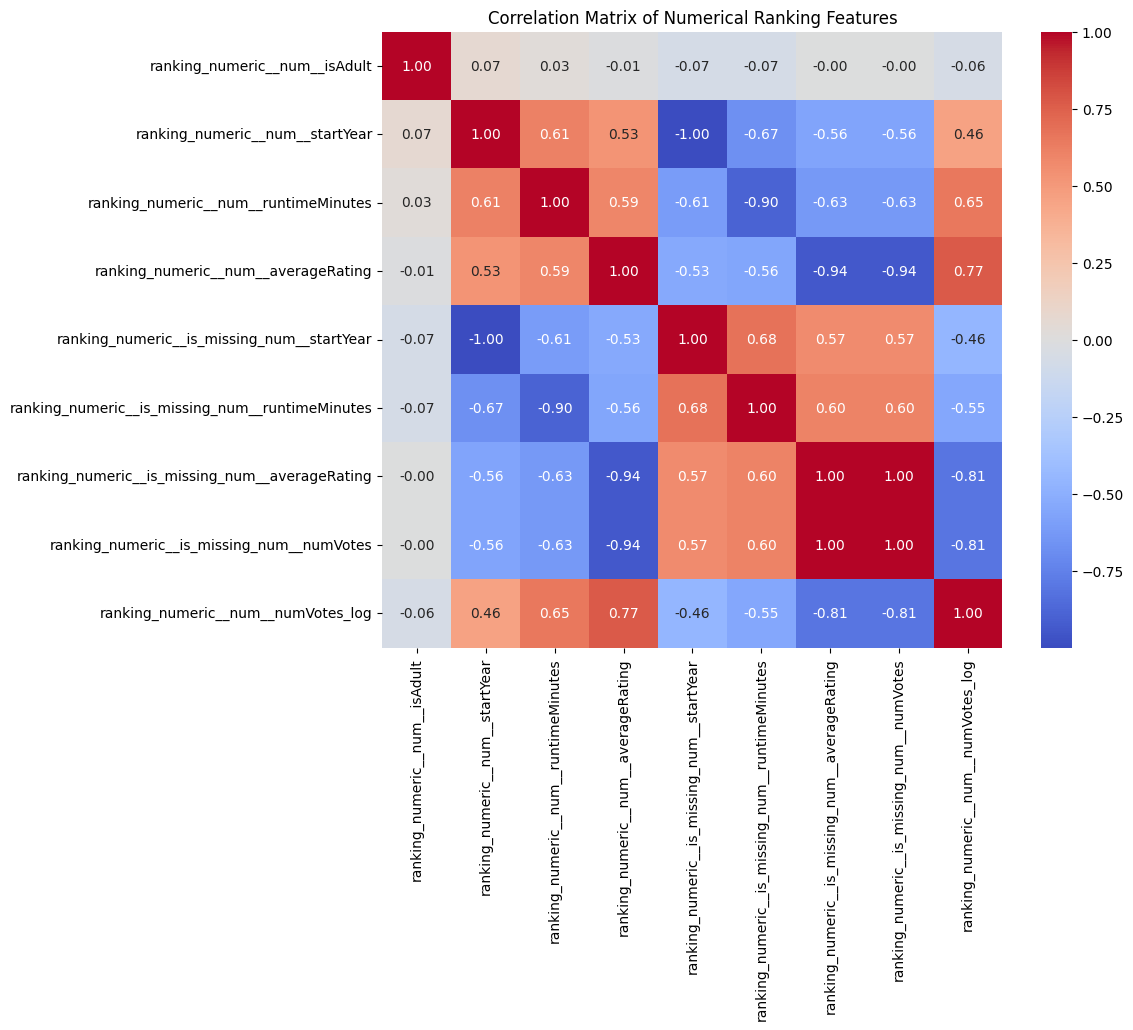

In [19]:
ranking_features = X_processed.filter(like='ranking_numeric')

plt.figure(figsize=(10, 8))
sns.heatmap(ranking_features.corr(), annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Correlation Matrix of Numerical Ranking Features')
plt.show()

### Interpretation

* The indicator flags (e.g., `is_missing_...`) are not highly correlated with other features, which is good (they provide unique information).
* `ranking_numeric__num__numVotes_log` and `ranking_numeric__num__averageRating` have a moderate positive correlation (0.42), which makes sense.
* No features are redundant (e.g., > 0.9 correlation), so we can keep all of them.

### Feature Importance

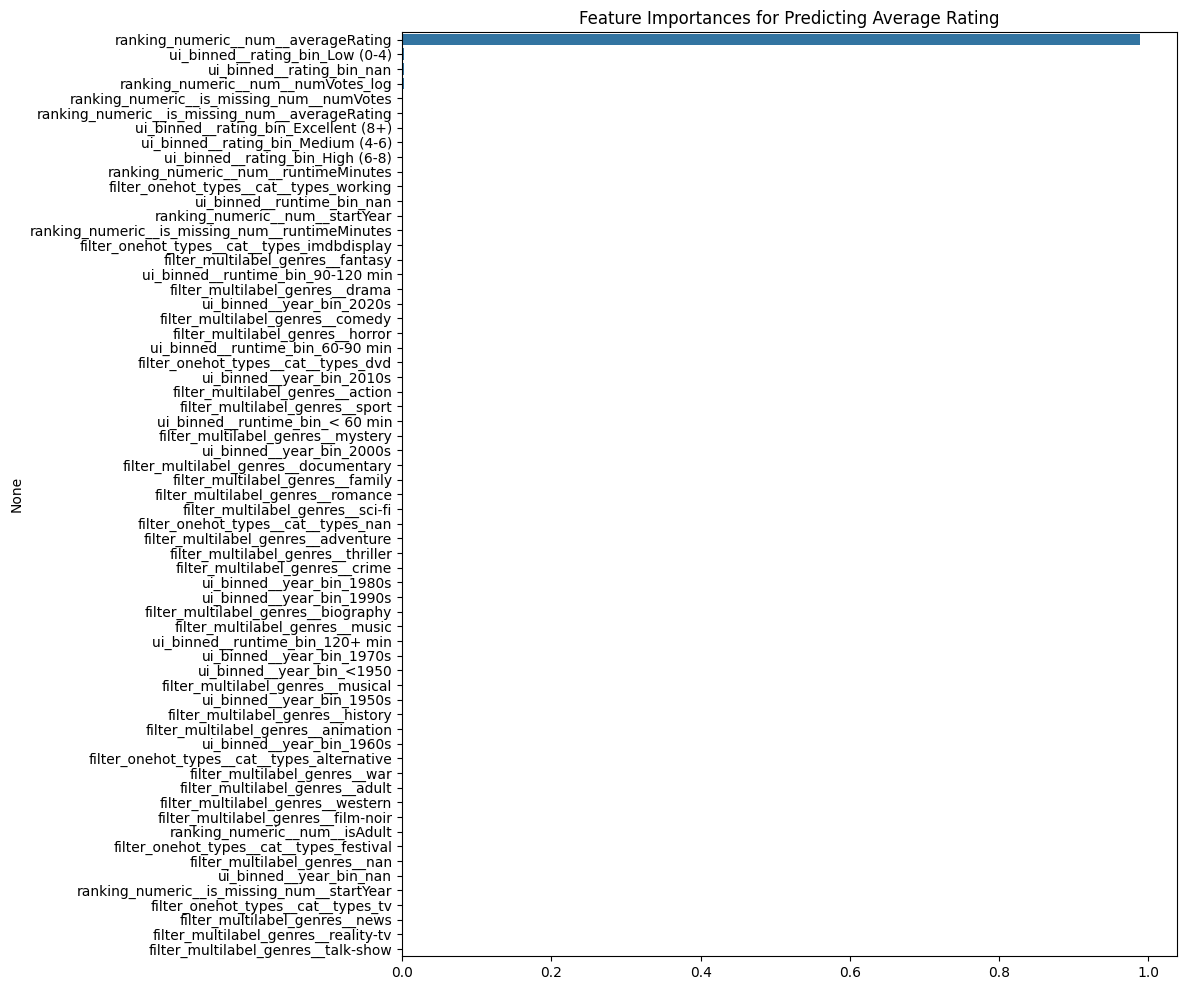

In [20]:
y_target = df_clean['num__averageRating'].fillna(0) 
X_features = X_processed.drop(columns=['search_corpus__searchable_text']) 
model_features = [col for col in X_features.columns if 
                  col.startswith('ranking_numeric') or 
                  col.startswith('filter_') or
                  col.startswith('ui_binned')]

X_model_data = X_features[model_features]

rf = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
rf.fit(X_model_data, y_target)

importances = pd.Series(rf.feature_importances_, index=X_model_data.columns).sort_values(ascending=False)

plt.figure(figsize=(10, 12))
sns.barplot(x=importances.values, y=importances.index)
plt.title('Feature Importances for Predicting Average Rating')
plt.show()

### Interpretation

* **`ranking_numeric__num__numVotes_log`** is by far the most important feature for predicting a film's rating.
* **Indicator features** (like `is_missing_num__averageRating` and `is_missing_num__numVotes`) are also important! This confirms that "missingness" itself is a useful signal, validating our strategy from Step 3.0.
* The binned features (`ui_binned__...`) also provide value.

## 8. Save Artifacts

In [21]:
print("--- Saving Artifacts ---")

# 1. Save the main preprocessor pipeline
joblib.dump(full_preprocessor, 'preprocessor.joblib')
print("1. preprocessor.joblib saved")

# 2. Save the TF-IDF vectorizer
joblib.dump(tfidf_vectorizer, 'tfidf_vectorizer.joblib')
print("2. tfidf_vectorizer.joblib saved")

# 3. Save the SBERT embeddings (The heavy computation result)
np.save('sbert_embeddings.npy', sbert_embeddings)
print("3. sbert_embeddings.npy saved")

--- Saving Artifacts ---
1. preprocessor.joblib saved
2. tfidf_vectorizer.joblib saved
3. sbert_embeddings.npy saved
